# Bike Count Data Preprocessing Notebook

[Add notes]

## Read in Extracted Data

In [1]:
# libraries
import sys
from pathlib import Path
import pandas as pd
import folium
import numpy as np

# define directory variables
REPO_ROOT = Path.cwd().parent
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
DATA_DIR = REPO_ROOT / 'data'
EXTRACTED_DIR = DATA_DIR / 'extracted'
PROCESSED_DIR = DATA_DIR / 'processed'
DATA_DIR.mkdir(exist_ok=True)

In [2]:
# read in extracted bike count data
df = pd.read_parquet(EXTRACTED_DIR / 'extracted_hourly_bike_count_data.parquet')

print(df.shape)
display(df.head())

(737758, 9)


,year,date_time_dt,site_id,site_name_raw,site_name,counter_id,counter_name,count,coords
452,2019,2019-01-01 07:00:00+01:00,100047535,Pont du Garigliano NO-SE,pont du garigliano,100047535-SC,pont du garigliano no-se,3,"48.839927,2.267151"
453,2019,2019-01-04 02:00:00+01:00,100047535,Pont du Garigliano NO-SE,pont du garigliano,100047535-SC,pont du garigliano no-se,1,"48.839927,2.267151"
454,2019,2019-01-07 06:00:00+01:00,100047535,Pont du Garigliano NO-SE,pont du garigliano,100047535-SC,pont du garigliano no-se,13,"48.839927,2.267151"
455,2019,2019-01-07 07:00:00+01:00,100047535,Pont du Garigliano NO-SE,pont du garigliano,100047535-SC,pont du garigliano no-se,55,"48.839927,2.267151"
456,2019,2019-01-07 08:00:00+01:00,100047535,Pont du Garigliano NO-SE,pont du garigliano,100047535-SC,pont du garigliano no-se,114,"48.839927,2.267151"


## Site Locations

The bike count data files were generated yearly. To better understand the geographic locations of the counter sites, here we visualize them on a map with the latitude and longitude values provided.

In [3]:
# clean and split coordinates values
s = (df['coords'].astype(str).str.strip().str.replace(r"\s+", "", regex=True))
latlon = s.str.split(",", expand=True)
df["lat"] = pd.to_numeric(latlon[0], errors="coerce")
df["lon"] = pd.to_numeric(latlon[1], errors="coerce")

# select and subset to coordinates
df_coord = df.dropna(subset=["lat", "lon"]).copy()
df_coord = df_coord[['site_id', 'site_name', 'lat', 'lon']]

# round to reduce tiny differences ; 4 decimals is approximately 11 meters
df_coord["lat_r"] = df_coord["lat"].round(4)
df_coord["lon_r"] = df_coord["lon"].round(4)

# subset to unique cases
unique_sites = df_coord[['site_id', 'site_name', 'lat_r', 'lon_r']].drop_duplicates().sort_values(by='site_name')

# display all the unique site locations
display(unique_sites)

,site_id,site_name,lat_r,lon_r
3326,100056226,avenue de la porte de charenton,48.8303,2.4006
452,100047535,pont du garigliano,48.8399,2.2672
11689,100047551,pont du garigliano,48.8399,2.2671
611360,100047535,pont du garigliano,48.8402,2.2673
776072,100047551,pont du garigliano,48.8399,2.2669
2832908,100047535,pont du garigliano,48.8399,2.2669
23148,100047546,quai de bercy,48.8295,2.3870
12994,100047542,quai de la marne,48.8912,2.3857
1632788,100047542,quai de la marne,48.8917,2.3853
5107573,100047542,quai de la marne,48.8913,2.3861


In [4]:
# map unique sites
m = folium.Map(location=[unique_sites["lat_r"].mean(), unique_sites["lon_r"].mean()], zoom_start=12, tiles="cartodb positron")

for _, r in unique_sites.iterrows():
    folium.CircleMarker(
        location=[r["lat_r"], r["lon_r"]],
        radius=5
    ).add_to(m)

m 

### Site Location Observations

- The map confirms that the five counter sites form five distinct geographic clusters.
- Reported latitude and longitude values vary across years, indicating that counters associated with a given site were repositioned over time or that their recorded locations changed due to measurement or reporting effects. The available data do not allow these possibilities to be distinguished.

---
## Counter Devices

Exploratory analysis of the counter data revealed that:

1) many zero-count days were recorded, which—given the traffic volume in Paris—strongly suggests periods of non-operation rather than true zero counts
2) the number of counters at a given site was not stable over time.
3) the pont du garigliano site uses two site_id values for counters that measure traffic in opposite directions across the bridge

### Zero-Count Days Analysis

Here we will visualize the zero-count days at each counter to better understand their patterns of operation.
To better understand counter operation, we examine the zero-count periods for each device.

In [5]:
from scripts.compute_zero_runs import compute_zero_runs

# copy the data
#counters = df.copy()
#counters = counters[['year', 'date_time_dt','site_id', 'site_name', 'counter_id', 'count']]

# compute the runs of zero-count days for each counter
    # compute daily counts per counter
    # subset to zero count days
    # compute consequative days of zero days (i.e., a run of zero days) using the date_time_dt variable
    # prepare result for ploting
zero_runs = compute_zero_runs(df, min_run_days = 1)

# show result
display(zero_runs)

,counter_id,run_id,start,end,n_days,start_num,end_num,width,y
0,100047542-101047542,1,2024-05-01,2024-05-02,2,19844.0,19845.0,2.0,0
1,100047542-101047542,2,2024-05-04,2024-05-08,5,19847.0,19851.0,5.0,0
2,100047542-101047542,3,2024-05-13,2024-05-13,1,19856.0,19856.0,1.0,0
3,100047542-101047542,4,2024-07-09,2024-07-11,3,19913.0,19915.0,3.0,0
4,100047542-102047542,5,2024-05-01,2024-05-08,8,19844.0,19851.0,8.0,1
5,100047542-102047542,6,2024-05-13,2024-05-13,1,19856.0,19856.0,1.0,1
6,100047542-102047542,7,2024-07-09,2024-07-11,3,19913.0,19915.0,3.0,1
7,100047542-103047542,8,2019-09-11,2019-09-23,13,18150.0,18162.0,13.0,2
8,100047542-103047542,9,2024-05-01,2024-05-08,8,19844.0,19851.0,8.0,2
9,100047542-103047542,10,2024-05-13,2024-05-13,1,19856.0,19856.0,1.0,2


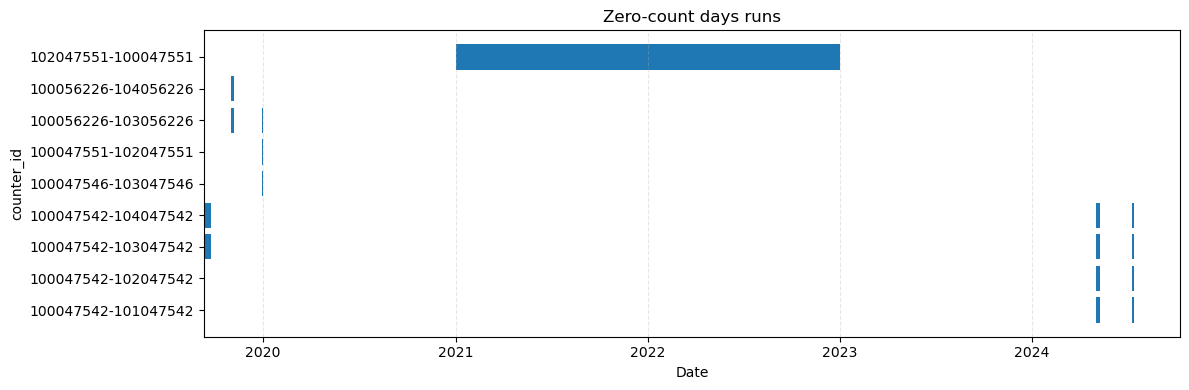

In [7]:
from scripts.plot_zero_runs import plot_zero_runs
# plot the runs of zero-count days over the span of 2019-2024 in a horizontal bar chart
plot_zero_runs(zero_runs, figsize=(12,4))

### Zero-Count Days: Observations

- Counter 102047551-100047551 recorded uninterrupted zero counts throughout 2021 and 2022.
- For all other counters, zero-count days occurred in temporally aligned runs across multiple devices, rather than sporadically.

### Zero-Count Days: Interpretation
- Counter 102047551-100047551 was evidently non-operational for an extended two-year period. Its zero counts will therefore be removed from the dataset.
- For all remaining counters, the zero-count patterns are unlikely to represent true zero traffic. Given Paris’s consistently high cycling activity, zero counts are implausible. Moreover, the temporal alignment of zero-count runs across counters indicates temporary but systematic periods of non-operation. These zero values will be recoded as missing (NaN).

In [20]:
# remove Counter 102047551-100047551 data from 2021 and 2022

# copy data
df1 = df.copy()

# subset data
df1 = df1[
    ~(
        (df1['counter_id'] == '102047551-100047551') &
        (df1['year'].isin(['2021','2022']))
    )
]

In [35]:
# assign NaN to hourly counts of zero-count days

# copy data
df2 = df1.copy()

# create day variable
df2['day'] = df2['date_time_dt'].dt.date 

# compute daily totals per counter
daily = (
    df2.groupby(['counter_id', 'day'], as_index=False)['count'].sum(min_count=1) 
)

# identify zero-count days
zero_days = daily.loc[daily['count'] == 0, ['counter_id', 'day']].copy()
zero_days['zero_day'] = True

# calculate expected NaN count
expected_NaN_in_result = (
    df2.merge(zero_days, on=['counter_id', 'day'], how='inner')
       .shape[0]
)

# merge zero_days to df2
df2 = df2.merge(zero_days, on=['counter_id', 'day'], how='left')

# recode zero days hours to missing
df2.loc[df2['zero_day'].eq(True), 'count'] = np.nan

# drop zero_day
df2 = df2.drop(columns=['zero_day'])

# validate NaN count
NaN_in_result = df2['count'].isna().sum()
print(f'Expected NaN count in result {expected_NaN_in_result}')
print(f'NaN count in result {NaN_in_result}')

Expected NaN count in result 1616
NaN count in result 1616


### Counters Per Site

This table shows the counters per site in the processed data.

Notably:

- pont du garigliano was associated with two distinct site_id values.
- all other sites had two active counters during the years 2019, 2020 and 2023, and four active counters during the years 2021, 2022, and 2024.

In [36]:
counters_per_site = df2.copy()
counters_per_site = counters_per_site.groupby(['site_id', 'site_name','year'])['counter_id'].nunique().reset_index(name='n_counters')
counters_per_site = counters_per_site.pivot(index=['site_id', 'site_name'], columns='year', values='n_counters').fillna(0)
counters_per_site

,year,2019,2020,2021,2022,2023,2024
site_id,site_name,,,,,,
100047535,pont du garigliano,1,1,1,1,1,1
100047542,quai de la marne,2,2,4,4,2,4
100047546,quai de bercy,2,2,4,4,2,4
100047547,rue julia bartet,2,2,4,4,2,4
100047551,pont du garigliano,1,1,1,1,1,1
100056226,avenue de la porte de charenton,2,2,4,4,2,4


Pont du Garigliano was associated with two distinct site_id values, each representing one direction of traffic flow. For analytical purposes, we define an alternative site_id that combines these two identifiers, allowing the bridge to be treated as a single site.

In [48]:
# copy data
df3 = df2.copy()

# create alt column
df3['site_id_alt'] = df3['site_id']

# identify the two Pont du Garigliano site_ids
garigliano_ids = {'100047535', '100047551'} 

# assign combined id to garigliano
mask = df3['site_id'].isin(garigliano_ids)
df3.loc[mask, 'site_id_alt'] = '100047535-100047551'

# examine result
unique_sites_alt = df3[['site_id_alt', 'site_name']].copy()
unique_sites_alt = unique_sites_alt.drop_duplicates(subset=['site_id_alt', 'site_name'])
display(unique_sites_alt)

,site_id_alt,site_name
0,100047535-100047551,pont du garigliano
434,100056226,avenue de la porte de charenton
1420,100047542,quai de la marne
2332,100047547,rue julia bartet
2833,100047546,quai de bercy


---

## High Count Days

Examine each counter to understand whether they show any unusual high-count days.

In [49]:
# aggregate across counter and date such that the result provide daily intervals
daily_counts = (
    df
    .groupby(['counter_id', pd.Grouper(key='date_time_dt', freq='D')])['count']
    .sum()
    .reset_index()
)

daily_counts.head()

,counter_id,date_time_dt,count
0,100047535-101047535,2023-01-01 00:00:00+01:00,390
1,100047535-101047535,2023-01-02 00:00:00+01:00,1062
2,100047535-101047535,2023-01-03 00:00:00+01:00,1941
3,100047535-101047535,2023-01-04 00:00:00+01:00,1663
4,100047535-101047535,2023-01-05 00:00:00+01:00,2018


In [50]:
daily_counts.counter_id.unique()

<StringArray>
['100047535-101047535',        '100047535-SC', '100047542-101047542',
 '100047542-102047542', '100047542-103047542', '100047542-104047542',
 '100047546-101047546', '100047546-102047546', '100047546-103047546',
 '100047546-104047546', '100047547-101047547', '100047547-102047547',
 '100047547-103047547', '100047547-104047547', '100047551-101047551',
 '100047551-102047551', '100056226-101056226', '100056226-102056226',
 '100056226-103056226', '100056226-104056226', '101047535-100047535',
 '101047542-100047542', '101047546-100047546', '101047547-100047547',
 '101047551-100047551', '101056226-100056226', '102047542-100047542',
 '102047546-100047546', '102047547-100047547', '102047551-100047551',
 '102056226-100056226', '103047542-100047542', '103047546-100047546',
 '103047547-100047547', '103056226-100056226', '104047542-100047542',
 '104047546-100047546', '104047547-100047547', '104056226-100056226']
Length: 39, dtype: string

In [ ]:
# normalize within counter × year × month
df["count_norm"] = (
    df.groupby(["counter_id", "year", "month"])["count"]
      .transform(lambda s: s / s.mean())
)


To focus on behavioral responses to weather rather than absolute volumes, counts are normalized within counter and year before aggregation, ensuring comparability despite changes in instrumentation and location.

In [ ]:
# drop coords column
df = df.drop('coords', axis=1)

# convert to local time
df['date_time'] = pd.to_datetime(df['date_time'].str.split('+').str[0])

In [ ]:
# examine unique counter id values
df['counter_id'].unique()

In [ ]:
# aggregate to monthly counts

monthly_counts = (
    df
    .groupby(['counter', pd.Grouper(key='date_time', freq='MS')])['count']
    .sum()
    .reset_index()
)

monthly_counts.head()

In [ ]:
# chart of monthly counts by counter

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10,5))
sns.lineplot(
    data=monthly_counts, 
    x='date_time', 
    y='count', 
    hue='counter',  # this creates separate lines for each counter
    marker='o'
)

locator = mdates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)

plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly Counts by Counter')
plt.xticks(rotation=45)
plt.legend(title='Counter')
plt.tight_layout()
plt.show()

### Observations on Monthly Counts
At a high level, there are several notable patterns:
- Quai de la Marne is the busiest counter with sizable upticks during summer and December.
- All five counters show an upward trend between January and July.
- Downturns occur in August, likely due to the efflux of travelers from Paris during the summer holiday season.
- All five counters show upticks in December, which is perhaps the most surprising trend because December is a colder and wetter month.

That the counts increase from January thru July supports the hypothesis that weather patterns contribute to cycling behavior. 

Surprisingly, counts were noticeably high in December, despite it being a colder and wetter season the preceding months.

In [ ]:
# aggregate across counter and date such that the result provide daily intervals

daily_counts = (
    df
    .groupby(['counter', pd.Grouper(key='date_time', freq='D')])['count']
    .sum()
    .reset_index()
)

daily_counts.head()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

g = sns.relplot(
    data=daily_counts,
    x='date_time',
    y='count',
    kind='line',
    row='counter',       
    height=2.5,          
    aspect=7,            
    marker='o',
    facet_kws={'sharex': True}   # share x-axis across all rows
)

g.fig.set_size_inches(12, 8)
g.set_axis_labels("Date Time", "Daily Count")
g.set_titles("{row_name}")

# Rotate ticks only on the bottom row (shared x-axis)
for ax in g.axes[-1]:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Observations on Daily Counts
- Quai de la Marne had an unusually high daily count followed by a stretch of days with zero counts, suggesting there might possibly have been a counter malfunction followed by a repair.
- Pont National displayed an overlapping period of zero count days.
- There were a cluster of days in December where all counters had surprisingly high counts.

Two of the counters were offline, so the missing data needs to be accounted for in subsequent modeling.

The December patterns warrant further investigation to understand if there might have been a city-wide event leading to high counts.

<font color='red'> # Next Step:  Show some work to identify the December days, and correlate that with strikes. </font> 


In [ ]:
# aggregate across counter and date such that the result provide 1-hour intervals

hourly_counts = (
    df
    .groupby(['counter', pd.Grouper(key='date_time', freq='h')])['count']
    .sum()
    .reset_index()
)

hourly_counts.head()

In [ ]:
# chart of hourly counts by counter

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")  

g = sns.relplot(
    data=hourly_counts,
    x='date_time',
    y='count',
    kind='line',
    col='counter',      
    col_wrap=5,             
    marker='o'
)

g.set_axis_labels("Date Time", "Hourly Count")
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# examining the hightest counts at each sensor
hourly_counts.sort_values('count', ascending = False).groupby('counter').head(5)

# the spike in decmper are likely related to the transit strike
# https://www.lemonde.fr/politique/article/2019/12/17/tous-les-syndicats-dans-la-rue-contre-la-reforme-des-retraites_6023141_823448.html